## Прогнозирование стоимости автомоблей

### Задача

На основании исторических данных разработать модель, которая предсказывает рыночную стоимость автомобиля в зависимости от его характеристик.

**Критерии оценки готовой модели:**
- качество предсказания
- время обучения модели
- время предсказания

**Доступные данные**</br>
</br>
**Признаки:**
- DateCrawled — дата скачивания анкеты из базы
- VenicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- NotRepaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя </br>
</br>

**Целевой признак:**
- Price — цена (евро)

### План работы

- Изучение данных 
- Предобработка и заполнение пропусков
- Подготовка признаков
- Исследование моделей
- Итоговое тестирование

### Резюме

Для работы предложены две модели:</b>
</br>
**Light GBM:**
- RMSE на тестовой выборке - 1545 
- время обучения - 34.9 c 
- время предсказания - 8.59 c 

**KNeighbors:**
- RMSE на тестовой - выборке 1774 
- время обучения - 2.01 c 
- время предсказания - 2.5 c 

In [1]:
!pip install catboost

In [2]:
!pip install lightgbm

In [3]:
#для начала импортируем необходимые библиотеки

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import pandas_profiling as pp
from datetime import datetime
import time

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.dummy import DummyRegressor

In [4]:
#определим константы 

RANDOM_STATE = 25

In [5]:
#откроем файл с данными

try:
    data = pd.read_csv('datasets/autos.csv')
except FileNotFoundError:
    data = pd.read_csv('/datasets/autos.csv')

## Изучение и предобработка данных

### Первичный анализ данных

Посмотрим на содержимое датасета, на котором будем обучать модель

In [6]:
#выведем основную информацию о датасете
display(data.head(), data.info(), data.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


None

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


Изучим основную информацию о признаках с помощью модуля pandasprofiling

In [7]:
#применим pandasprofiling
pp.ProfileReport(data, minimal=True)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Изучим корреляцию численных признаков

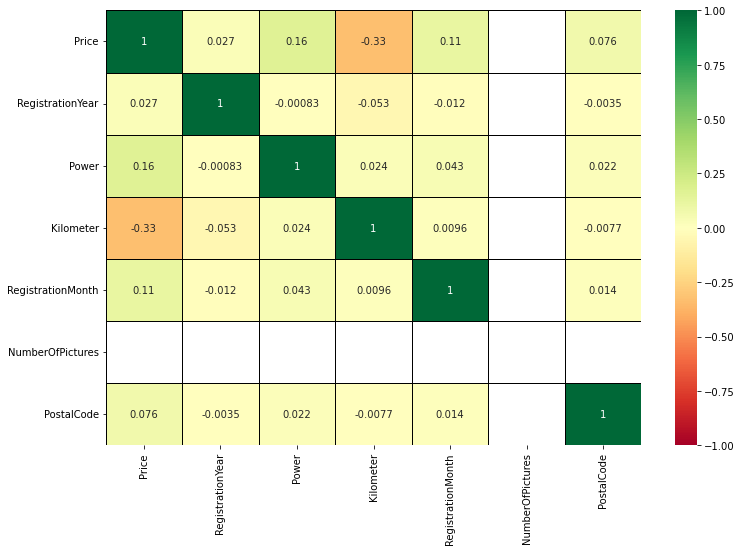

In [8]:
#выводим график корреляции
fig = plt.figure(figsize=(12, 8))
sns.heatmap(data.corr(), annot = True, vmin = -1, vmax = 1, center = 0, cmap= 'RdYlGn', linewidths = 1, linecolor = 'black')
plt.show()

Изучим уникальные значения и дубликаты

In [9]:
#смотрим количество уникальных значений в каждом столбце
data.nunique().sort_values()

NumberOfPictures          1
Gearbox                   2
NotRepaired               2
FuelType                  7
VehicleType               8
Kilometer                13
RegistrationMonth        13
Brand                    40
DateCreated             109
RegistrationYear        151
Model                   250
Power                   712
Price                  3731
PostalCode             8143
LastSeen             179150
DateCrawled          271174
dtype: int64

In [10]:
#для некоторых столбцов выведем уникальные значения
list_of_columns = ['Gearbox', 'NotRepaired', 'FuelType', 'VehicleType', 'Kilometer', 'Brand']
for name in list_of_columns:
    print(name, ':', data[name].unique())

Gearbox : ['manual' 'auto' nan]
NotRepaired : [nan 'yes' 'no']
FuelType : ['petrol' 'gasoline' nan 'lpg' 'other' 'hybrid' 'cng' 'electric']
VehicleType : [nan 'coupe' 'suv' 'small' 'sedan' 'convertible' 'bus' 'wagon' 'other']
Kilometer : [150000 125000  90000  40000  30000  70000   5000 100000  60000  20000
  80000  50000  10000]
Brand : ['volkswagen' 'audi' 'jeep' 'skoda' 'bmw' 'peugeot' 'ford' 'mazda'
 'nissan' 'renault' 'mercedes_benz' 'opel' 'seat' 'citroen' 'honda' 'fiat'
 'mini' 'smart' 'hyundai' 'sonstige_autos' 'alfa_romeo' 'subaru' 'volvo'
 'mitsubishi' 'kia' 'suzuki' 'lancia' 'toyota' 'chevrolet' 'dacia'
 'daihatsu' 'trabant' 'saab' 'chrysler' 'jaguar' 'daewoo' 'porsche'
 'rover' 'land_rover' 'lada']


Интересный момент - в типе топлива совсем нет дизеля, а "бензин" встречается в двух вариантах написания - американоязычное 'gasoline' и британоязычное 'petrol'

In [11]:
#проверим явные дубликаты
data.duplicated().sum()

4

### Выводы

В нашем распоряжении датасет из 354 369 объектов с 16-ю признаками, включая целевой. 7 из этих признаков числовые, остальные - категориальные. В данных есть пропущенные и аномальные значения.</br>
Мультиколлинеарности численных признаков нет, наибольшая корреляция у целевого признака с величиной пробега.</br>
</br>
Пропущенные значения:
- VehicleType - 10,6%
- Gearbox - 5,6%
- Model - 5,6%
- FuelType - 9,3%
- NotRepaired - 10,1%</br>
</br>

Есть нули в колонках с мощностью двигателя, месяцем регистрации и ценой (целевой признак).</br>
Экстремально большие значения есть в колонках - мощность двигателя, цена, год регистрации.</br>
Столбец с числом картинок заполнен нулями.</br>
Есть 4 дубликата.</br>
</br>
Далее мы заполним пропуски, удалим дубликаты, приведем названия и форматы столбцов к более удобному виду.

### Предобработка данных

Приведём все названия столбцов к нижнему регистру, удалим 4 явных дубликата и переведем столбцы с датами в формат datetime

In [12]:
#зафиксируем размер и средние датасета до преобразований
data_len_start = len(data)
data_describe_start = data.describe()

In [13]:
#приводим названия колонок к нижнему регистру
data.columns = map(str.lower, data.columns)

In [14]:
#удаляем дубликаты
data.drop_duplicates(inplace=True);

In [15]:
#приводим столбцы с датами к нужному формату
data['datecrawled'] = pd.to_datetime(data['datecrawled'], format='%Y-%m-%dT%H:%M:%S')
data['datecreated'] = pd.to_datetime(data['datecreated'], format='%Y-%m-%dT%H:%M:%S')
data['lastseen'] = pd.to_datetime(data['lastseen'], format='%Y-%m-%dT%H:%M:%S')

Пропуски будем заполнять, базируясь на информации о бренде, модели и годе регистрации автомобиля.</br>
</br>
Однако, пропуски в колонке с моделью автомобиля сложно заполнить достоверно, поэтому строки с пропусками в этой колонке мы удалим как неинформативные - это около 5.6% датасета.</br>

In [16]:
print('Доля данных с пропущенным название модели', data.query('model != model')['brand'].count()/len(data))

Доля данных с пропущенным название модели 0.05560650741467131


In [17]:
#удаляем строки с пропущенными названиями моделей
data = data.dropna(subset = ['model']).reset_index(drop=True);

Определим функцию для заполнения пропусков: для каждого nan она будет группировать датасет по бренду, модели и году выпуска автомобиля и вычислять моду для столбца с пропущенным значением. </br>
Если вдруг для сочетания бренд-модель-год не найдется данных, то заполнение будет вестись модой только по бренду.

In [18]:
def na_replace(column_name):
    data[column_name].fillna(
    data.groupby(['brand', 'model', 'registrationyear'])[column_name]
    .transform(lambda x: x.value_counts().idxmax() if x.count() != 0 
               else data.groupby('brand')[column_name].transform(lambda x: x.value_counts().idxmax())), inplace=True)
    
    return data

In [19]:
#заменим пропуски в данных о типе коробки
na_replace('gearbox');

In [20]:
#восстановим тип топлива
na_replace('fueltype');

In [21]:
#тип кузова
na_replace('vehicletype');

Была ли машина в ремонте или нет - не зависит от модели и бренда, а также от других имеющихся у нас характеристик (хотя, чисто теоретически, можно сказать, что чем старше машина - тем больше веротяность, что она хотя бы раз потребовала серьезного ремонта, но мы оставим поиск этих зависимостей машинному обучению :). Для заполнения пропусков в столбце notrepaired создадим отдельную категорию 'noinfo'.

In [22]:
data['notrepaired'].fillna('noinfo', inplace=True)

Следующим этапом изучим и удалим выбросы в столбцах с годом регистрации, пробегом, мощностью двигателя и ценой.

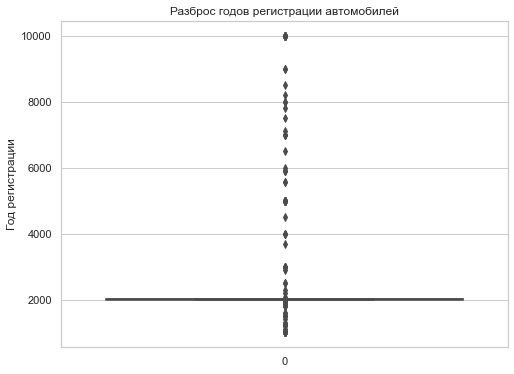

In [23]:
plt.figure(figsize=(8,6))
sns.set(style="whitegrid")
plt.title('Разброс годов регистрации автомобилей', fontsize=12)
#plt.xlabel('')
plt.ylabel('Год регистрации')
sns.boxplot(data=data['registrationyear']);
plt.show()

In [24]:
display(data['datecrawled'].max(), data['lastseen'].max())

Timestamp('2016-04-07 14:36:58')

Timestamp('2016-04-07 14:58:51')

Как видим, разброс годов регистрации достаточно большой. Удалим машины, "зарегистрированные" ранее 1960го и позднее 2016 года. Верхняя граница обусловлена тем, что последняя дата скачивания данных из базы ограничена 2016 годом. Поскольку речь идет о европейском и американском рынке, то там нередко встречаются машины, выпущенные и 50 лет назад. Автомобили ранее 1960го посчитаем раритетом с отдельным механизмом ценообразования.

In [25]:
len_before = len(data)
data = data.query('registrationyear <= 2016 & registrationyear >= 1960')
delete_share = (len_before - len(data))/len_before
print(f'Удалено {delete_share:.2%} датасета')

Удалено 3.80% датасета


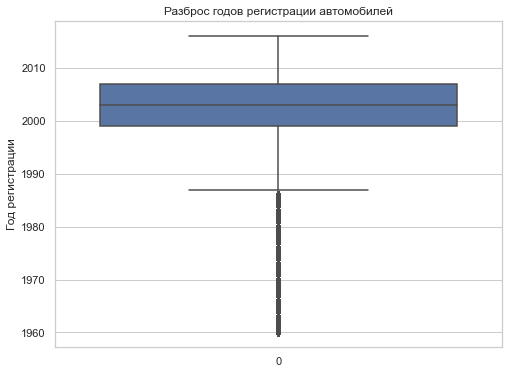

In [26]:
#выведем график еще раз
plt.figure(figsize=(8,6))
sns.set(style="whitegrid")
plt.title('Разброс годов регистрации автомобилей', fontsize=12)
#plt.xlabel('')
plt.ylabel('Год регистрации')
sns.boxplot(data=data['registrationyear']);
plt.show()

Добавим категорию с возрастом автомобиля:

In [27]:
def age_category(age):
    if age >= 2014:
        return 'quite_new'
    elif age >= 2010:
        return 'not_new'
    elif age >=2007:
        return 'not_so_old'
    elif age >= 2002:
        return 'semi_old'
    elif age >= 1997:
        return 'old'
    elif age >= 1987:
        return 'hard_old'
    elif age >= 1977:
        return 'retro'
    else:
        return 'hard_retro'

In [28]:
data['age_category'] = data.apply(lambda x: age_category(x.registrationyear), axis=1)

Построим ящик с усами для значения пробега:

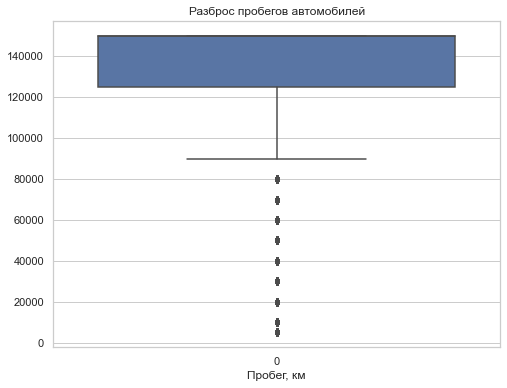

In [29]:
plt.figure(figsize=(8,6))
sns.set(style="whitegrid")
plt.title('Разброс пробегов автомобилей', fontsize=12)
plt.xlabel('Пробег, км')
#plt.ylabel('')
sns.boxplot(data=data['kilometer']);
plt.show()

Видим, что есть выбросы в виде небольших пробегов - здесь речь может идти о новых машинах, поэтому удалять их не будем.

Изучим значения мощности двигателя:

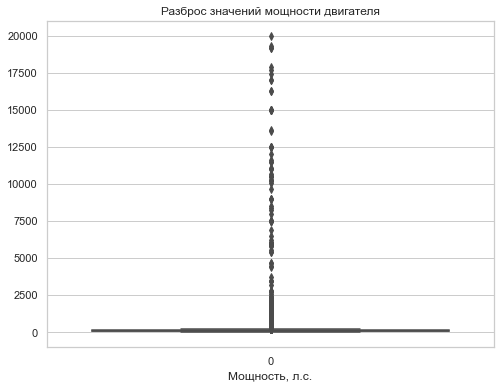

In [30]:
plt.figure(figsize=(8,6))
sns.set(style="whitegrid")
plt.title('Разброс значений мощности двигателя', fontsize=12)
plt.xlabel('Мощность, л.с.')
#plt.ylabel('')
sns.boxplot(data=data['power']);
plt.show()

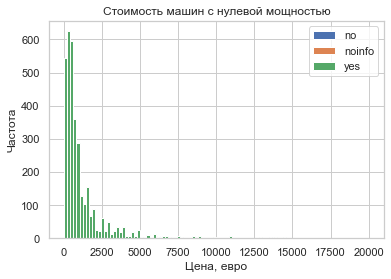

In [88]:
data.query('power == 0').groupby('notrepaired')['price'].hist(bins=100, legend=True);
plt.title('Стоимость машин с нулевой мощностью', fontsize=12)
plt.xlabel('Цена, евро')
plt.ylabel('Частота')
plt.show()

In [32]:
data.query('power == 0').groupby('notrepaired')['price'].count()

notrepaired
no        11442
noinfo    15441
yes        3913
Name: price, dtype: int64

Беглый обзор информации о самых мощных двигателях для гражданских моделей говорит о том, что двигатели мощностью меньше 50 и больше 500 л.с. на современном рынке встречаются редко. </br>
Тем не менее, машины с нулевой мощностью могут быть просто машинами без двигателя. Как дифференцировать их от пропусков и просто небрежности заполнения? В первую очередь, это будет видно по цене, во-вторую, по отметке о ремонте. Возьмем информацию о ремонте как основную - если машина не ремонтировалась или нет информации, априори считаем нулевое значение мощности ошибкой. Если же машина ремонтировалась, оставляем всё как есть. 

In [33]:
anomal_share = (
    (data.query('notrepaired == "no" and power < 50 and power <= 500')['power'].count() 
     + data.query('notrepaired == "noinfo" and power < 50 and power <= 500')['power'].count())/len(data)
)

In [34]:
print(f'Доля аномальных значений в столбце power: {anomal_share:.2%} ')

Доля аномальных значений в столбце power: 9.69% 


In [36]:
#определим функцию проверки ремонтировалась/не ремонтировалась машина
def power_check(df):
    if df.loc['notrepaired'] == 'no' or df.loc['notrepaired'] == 'noinfo':
        if df.loc['power'] <= 50 or df.loc['power'] >= 500:
            return np.nan
        else:
            return df.loc['power']
    if df.loc['notrepaired'] == 'yes':
        if df.loc['power'] >= 500:
            return np.nan
        else:
            return df.loc['power']

In [37]:
data['power'] = data.apply(power_check, axis=1)

In [39]:
#заполним пропуски ранее созданной функцией
na_replace('power');

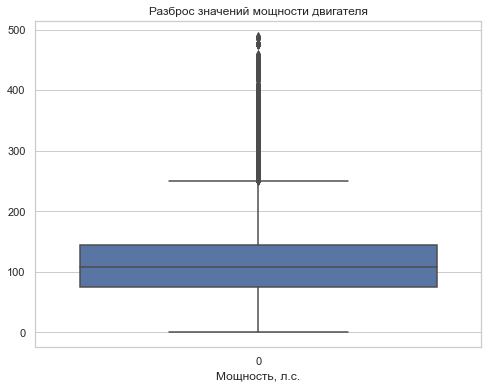

In [40]:
#выведем график еще раз
plt.figure(figsize=(8,6))
sns.set(style="whitegrid")
plt.title('Разброс значений мощности двигателя', fontsize=12)
plt.xlabel('Мощность, л.с.')
#plt.ylabel('')
sns.boxplot(data=data['power']);
plt.show()

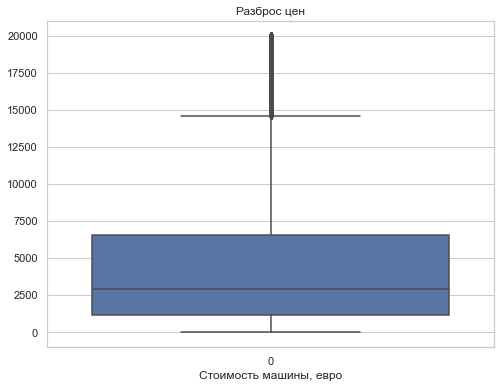

In [41]:
#и наконец выведем ящик с усами для цены
plt.figure(figsize=(8,6))
sns.set(style="whitegrid")
plt.title('Разброс цен', fontsize=12)
plt.xlabel('Стоимость машины, евро')
#plt.ylabel('')
sns.boxplot(data=data['price']);
plt.show()

Видим, что в выборке есть и очень большие цены и нули. Нули посчитаем аномалией - вряд ли кто-то хочет отдать машину бесплатно. Посчитаем нижней границей стоимости 50 евро.

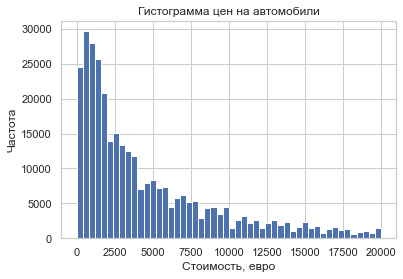

In [42]:
data['price'].hist(bins=50);
plt.title('Гистограмма цен на автомобили', fontsize=12)
plt.xlabel('Стоимость, евро')
plt.ylabel('Частота')
plt.show()

In [43]:
anomal_share = data.query('price <= 0')['brand'].count()/len(data)
print(f'Доля нулевых значений в столбце price: {anomal_share:.2%} ')

Доля нулевых значений в столбце price: 2.48% 


In [44]:
anomal_share = data.query('price <= 50')['brand'].count()/len(data)
print(f'Доля цен менее 50 евро: {anomal_share:.2%} ')

Доля цен менее 50 евро: 2.95% 


In [45]:
len_before = len(data)
data = data.query('price >= 50')
delete_share = (len_before - len(data))/len_before
print(f'Удалено {delete_share:.2%} датасета')

Удалено 2.86% датасета


Выведем общую информацию об итоговом датасете.

In [46]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 312736 entries, 0 to 334659
Data columns (total 17 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   datecrawled        312736 non-null  datetime64[ns]
 1   price              312736 non-null  int64         
 2   vehicletype        312736 non-null  object        
 3   registrationyear   312736 non-null  int64         
 4   gearbox            312736 non-null  object        
 5   power              312736 non-null  float64       
 6   model              312736 non-null  object        
 7   kilometer          312736 non-null  int64         
 8   registrationmonth  312736 non-null  int64         
 9   fueltype           312736 non-null  object        
 10  brand              312736 non-null  object        
 11  notrepaired        312736 non-null  object        
 12  datecreated        312736 non-null  datetime64[ns]
 13  numberofpictures   312736 non-null  int64   

In [47]:
data_len_finshare = (data_len_start - len(data))/data_len_start
print(f'В процессе предобработки удалено: {data_len_finshare:.2%} данных')

В процессе предобработки удалено: 11.75% данных


In [48]:
display("Средние значения до предобработки:", data.describe().loc['mean', :], 'Средние значения после предобработки:', data_describe_start.loc['mean', :])

'Средние значения до предобработки:'

price                  4688.649580
registrationyear       2002.783530
power                   118.230133
kilometer            128528.599202
registrationmonth         5.901163
numberofpictures          0.000000
postalcode            50914.415942
Name: mean, dtype: float64

'Средние значения после предобработки:'

Price                  4416.656776
RegistrationYear       2004.234448
Power                   110.094337
Kilometer            128211.172535
RegistrationMonth         5.714645
NumberOfPictures          0.000000
PostalCode            50508.689087
Name: mean, dtype: float64

### Выводы

Была проведена предварительная обработка данных, заполнение пропусков и удаление выбросов. В процессе было удалено порядка 12% данных, а средние значения численных переменных изменились не сильно. </br>
Предобработка столбцов datecrawled, registrationmonth, datecreated, numberofpictures, postalcode и lastseen не проводилась, т.к. эти данные не будут участовать в обучении.

## Подготовка и отбор признаков

**Изучение целевого признака**

Выведем информацию о целевом признаке и его зависимости от остальных признаков:

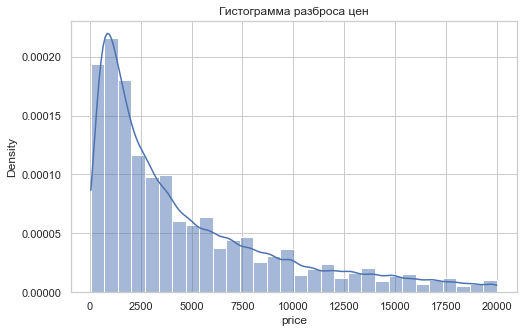

In [49]:
plt.figure(figsize=(8,5))
sns.set(style="whitegrid")
sns.histplot(data['price'], bins=30, color='b', kde=True, stat='density');
plt.title('Гистограмма разброса цен', fontsize=12)
plt.show()

In [50]:
list_of_features = ['vehicletype', 'registrationyear', 'gearbox', 'kilometer', 'fueltype', 'brand', 'notrepaired']

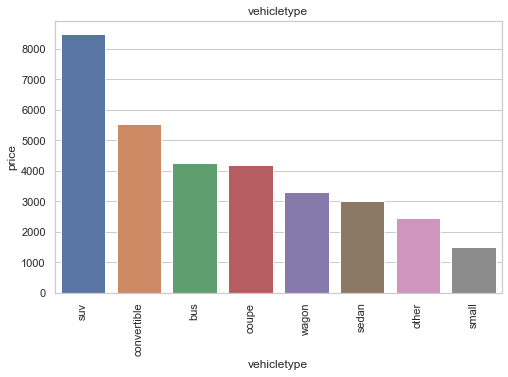

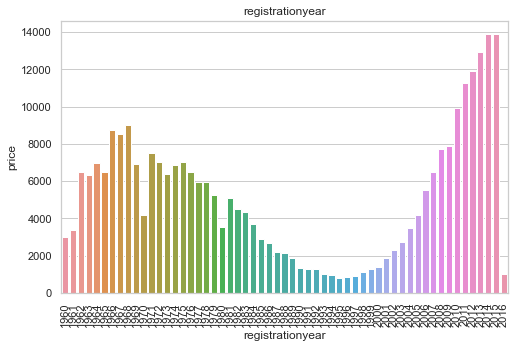

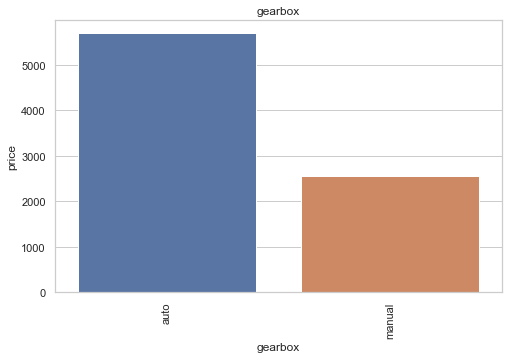

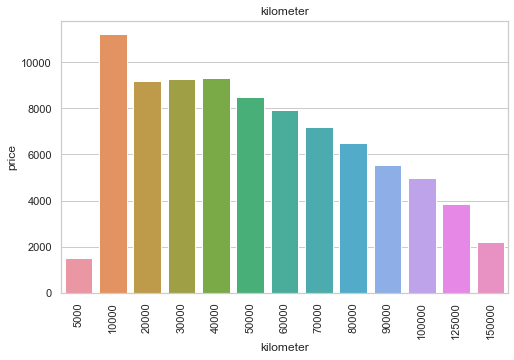

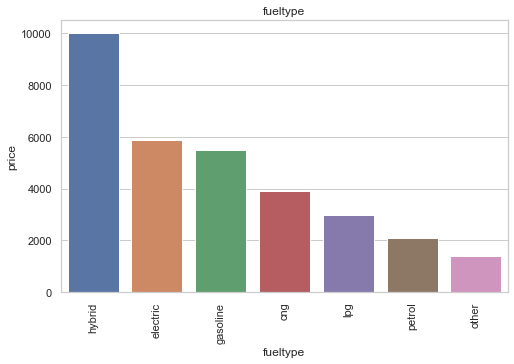

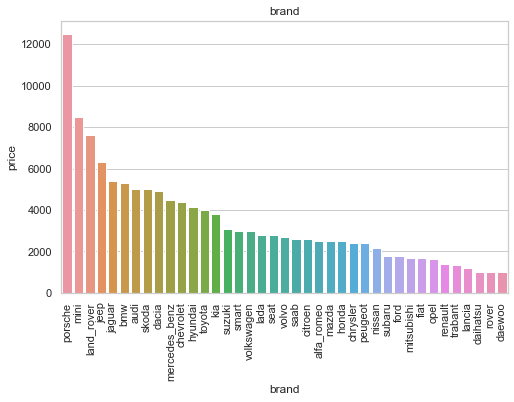

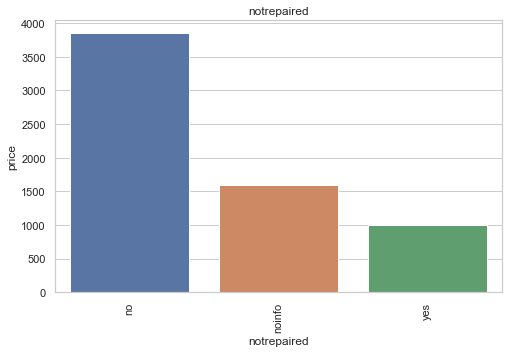

In [51]:
for feature in list_of_features:
    plt.figure(figsize=(8,5))
    sns.set(style="whitegrid")
    sns.barplot(x=data.groupby(feature)['price'].median().sort_values(ascending=False).index, y=data.groupby(feature)['price'].median().sort_values(ascending=False));
    plt.title(feature, fontsize=12)
    plt.xticks(rotation = 90)
    plt.show()

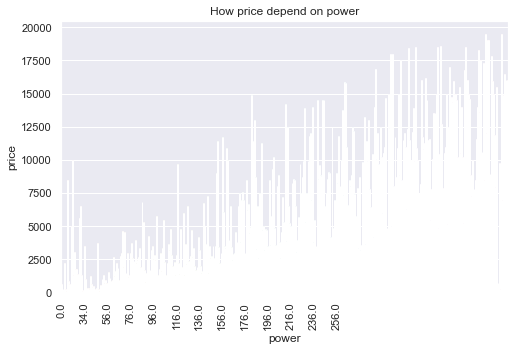

In [52]:
plt.figure(figsize=(8,5))
sns.set(style="darkgrid")
ax = sns.barplot(x=data.groupby('power')['price'].median().sort_values(ascending=False).index, y=data.groupby('power')['price'].median().sort_values(ascending=False));
plt.title('How price depend on power', fontsize=12)
plt.xticks(range(0, 251, 20))
#ax.set_xticklabels([])
#ax.grid([0, 50, 100, 150, 200, 250, 300])
plt.xticks(rotation = 90)
plt.show()

Видим, что более половины цен лежат в диапазоне до 2700 евро (это мы видели и раньше из описательной статистики датасета), а 75% цен лежат в диапазоне до 6400 евро. Однако в данных мы видим две "аномалии" с общепринятой точки зрения - машины с небольшим пробегом имеют очень низкую цену. Так же, как и машины, зарегистрированные в 2016 году - хотя обычно более новые автомобили стоят дороже.</br>
Кроме того, средняя цена на gasoline и petrol сильно различается, хотя и то, и другое - "бензин". Не исключено, что речь идет о разных регионах с разными ценовыми политиками.

Изучим зависимость цены от пробега

In [53]:
data.groupby('kilometer')['price'].median()

kilometer
5000       1500.0
10000     11250.0
20000      9199.0
30000      9300.0
40000      9307.0
50000      8500.0
60000      7950.0
70000      7200.0
80000      6499.0
90000      5550.0
100000     4998.0
125000     3850.0
150000     2200.0
Name: price, dtype: float64

<AxesSubplot:xlabel='registrationyear'>

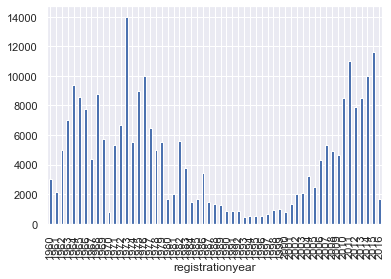

In [54]:
data.query('kilometer <= 5000').groupby('registrationyear')['price'].median().plot(kind='bar')

Во-первых, пробег в датасете дается дискретными значениями (вероятно, при заполнении в базе нужно указать диапазон, который потом записывается по верхней границе). Во-вторых, в диапазон "5000 и меньше" попало много старых машин с невысокой ценой - то ли владельцы всю жизнь хранили их в гараже, то ли не потрудились заполнить реальный пробег. В итоге средняя цена для диапазона 5000 очень низкая - но график распределения цен по годам внутри этого пробега вполне соответствует графику по всему датасету.

Посмотрим, как дела обстоят с ценами за 2016 год

In [55]:
data.query('registrationyear >= 2016').groupby(['registrationyear'])['price'].median()

registrationyear
2016    1000.0
Name: price, dtype: float64

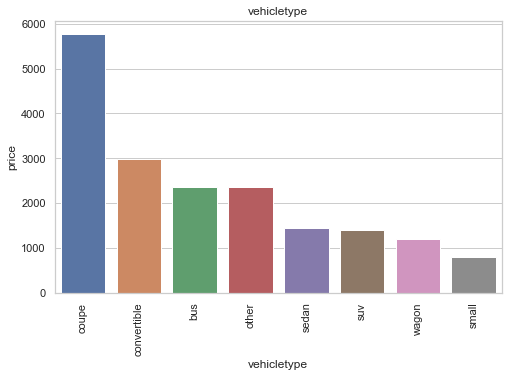

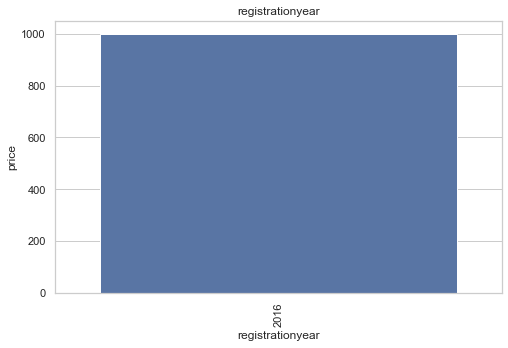

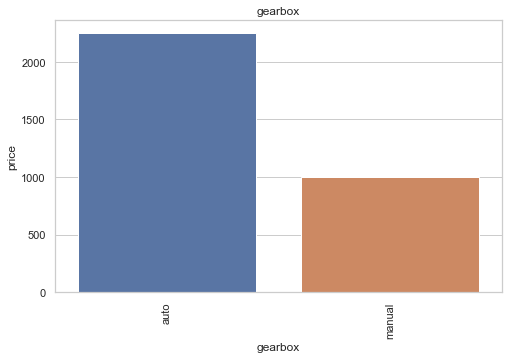

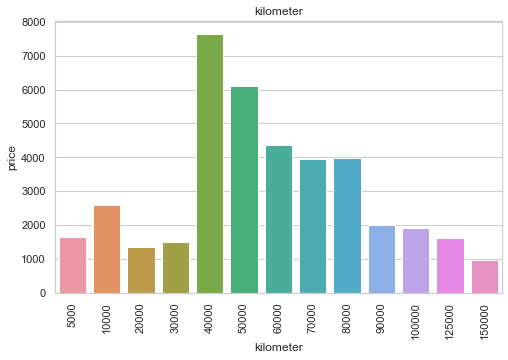

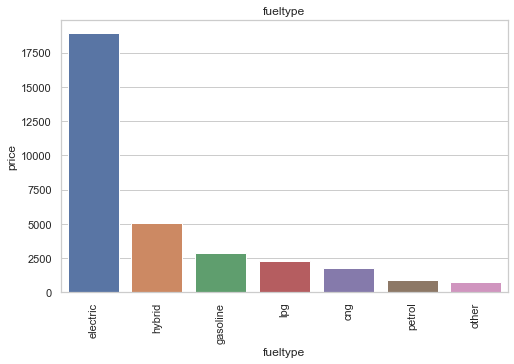

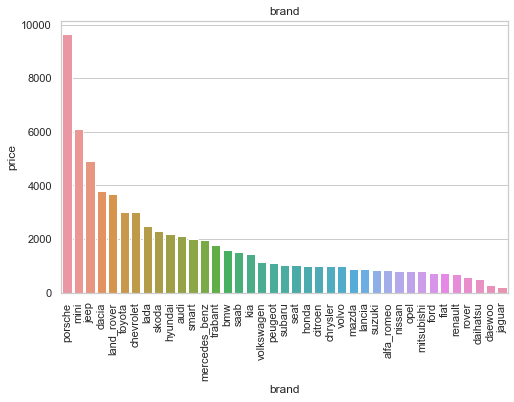

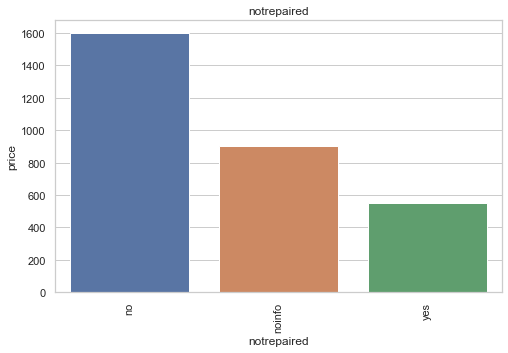

In [56]:
for feature in list_of_features:
    plt.figure(figsize=(8,5))
    sns.set(style="whitegrid")
    sns.barplot(x=data.query('registrationyear >= 2016')
                .groupby(feature)['price'].median().sort_values(ascending=False).index, 
                y=data.query('registrationyear >= 2016').groupby(feature)['price'].median().sort_values(ascending=False));
    plt.title(feature, fontsize=12)
    plt.xticks(rotation = 90)
    plt.show()

In [57]:
print('Соотношение gasoline/petrol в общем датасете:', data.query('fueltype == "gasoline" ')['price'].count()/data.query('fueltype == "petrol" ')['price'].count())
print('Соотношение gasoline/petrol c 2016 года:', data.query('fueltype == "gasoline" and registrationyear >= 2016')['price'].count()/data.query('fueltype == "petrol" and registrationyear >= 2016')['price'].count())

Соотношение gasoline/petrol в общем датасете: 0.44853412821190053
Соотношение gasoline/petrol c 2016 года: 0.20831350150721878


Нельзя сказать однозначно, что на снижение цены за последние годы повлиял какой-то конкретный фактор. В данных за 2016 год доля автомобилей с типом топлива gasoline заметно меньше, чем в общем по датасету, меньше машин с пробегом 20к и 30к. Возможно, это особенность рынка, возможно за последние годы у нас есть не все данные.</br>
В текущем проекте, когда тестовая выборка создается из имеющегося массива данных, на результат эта особенность скорее всего не повлияет. Но в реальной работе алгоритм может давать сбои при предсказании цен на машины с маленьким возрастом и пробегом.

**Отбор и подготовка признаков**

Подготовим два датасета - в один из них включим колонку 'postalcode', чтобы понять, влияет ли регион на результат.</br>
Разобьем данные на обучающую и тестовую выборки, закодируем категориальные признаки.

In [58]:
data_work = data[['vehicletype', 'registrationyear', 'gearbox', 'power', 'model', 'kilometer', 'fueltype', 'brand', 'notrepaired', 'age_category']]
target = data['price']

In [59]:
data_train, data_test, target_train, target_test = train_test_split(data_work, target, test_size = 0.20, random_state=RANDOM_STATE)

In [60]:
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
encoder.fit(data_train)

OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

In [62]:
data_train_ord = pd.DataFrame(encoder.transform(data_train), columns=data_train.columns)
data_test_ord = pd.DataFrame(encoder.transform(data_test), columns=data_test.columns)

In [63]:
data_train_ohe = pd.get_dummies(data_train, drop_first=True)
data_test_ohe = pd.get_dummies(data_test, drop_first=True)

In [64]:
data_train_ord.head()

,vehicletype,registrationyear,gearbox,power,model,kilometer,fueltype,brand,notrepaired,age_category
0,4.0,17.0,1.0,72.0,166.0,7.0,6.0,24.0,0.0,6.0
1,4.0,49.0,1.0,125.0,11.0,12.0,2.0,2.0,1.0,3.0
2,7.0,47.0,1.0,83.0,42.0,12.0,2.0,24.0,0.0,3.0
3,5.0,49.0,1.0,42.0,169.0,7.0,6.0,9.0,0.0,3.0
4,2.0,41.0,1.0,100.0,11.0,12.0,6.0,2.0,0.0,4.0


In [65]:
data_train_ohe.head()

,registrationyear,power,kilometer,vehicletype_convertible,vehicletype_coupe,vehicletype_other,vehicletype_sedan,vehicletype_small,vehicletype_suv,vehicletype_wagon,...,brand_volvo,notrepaired_noinfo,notrepaired_yes,age_category_hard_retro,age_category_not_new,age_category_not_so_old,age_category_old,age_category_quite_new,age_category_retro,age_category_semi_old
286109,1977,90.0,70000,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
207306,2009,143.0,150000,0,0,0,1,0,0,0,...,0,1,0,0,0,1,0,0,0,0
145198,2007,101.0,150000,0,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
196046,2009,60.0,70000,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
104787,2001,118.0,150000,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [66]:
data_work_geo = data[['vehicletype', 'registrationyear', 'gearbox', 'power', 'model', 'kilometer', 'fueltype', 'brand', 'notrepaired', 'postalcode', 'age_category']]
target_geo = data['price']

In [67]:
data_train_geo, data_test_geo, target_train_geo, target_test_geo = train_test_split(data_work_geo, target_geo, test_size = 0.20, random_state=RANDOM_STATE)

In [68]:
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
encoder.fit(data_train_geo)

OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

In [69]:
data_train_geo_ord = pd.DataFrame(encoder.transform(data_train_geo), columns=data_train_geo.columns)
data_test_geo_ord = pd.DataFrame(encoder.transform(data_test_geo), columns=data_test_geo.columns)

In [70]:
data_train_geo_ohe = pd.get_dummies(data_train_geo, drop_first=True)
data_test_geo_ohe = pd.get_dummies(data_test_geo, drop_first=True)

### Выводы

Мы изучили зависимость целевого признака от остальных признаков и обнаружили нестандартные зависимости, которые (теоретически) могут ухудшить работу модели в будущем на определенных данных.</br>
Для обучения моделей мы подготовили две выборки - в почтовым индексом и без, разбили их на обучающую и тестовую выборки,  закодировали категориальные переменные с помощью методов OHE для линейных моделей и OrdinalEncoder для остальных.

## Обучение моделей

Рассмотрим несколько моделей - линейную регрессию, ElasticNet, метод ближайших соседей, CatBoost и LightGBM. В качестве метрики будем использовать RMSE. Для подбора параметров используем GridSearch, для оценки результатов - кросс-валидацию. Для каждой модели будем фиксировать метрику и время работы алгоритма.

In [71]:
#определим метрику
def rmse(target, predict):
    return mean_squared_error(target, predict) ** 0.5

In [72]:
#сделаем из неё скорер
scoring = make_scorer(rmse, greater_is_better = False)

**Линейные модели - простая линейная регрессия и ElasticNet**

In [73]:
%%time

lr = LinearRegression()
result = cross_val_score(lr, data_train_ohe, target_train, cv=5, scoring=scoring)

time_fit_start = datetime.now()
lr.fit(data_train_ohe, target_train)
time_fit_end = datetime.now()
time_fit_diff = time_fit_end - time_fit_start

time_pred_start = datetime.now()
lr.predict(data_train_ohe)
time_pred_end = datetime.now()
time_pred_diff = time_pred_end - time_pred_start

print('RMSE линейной регрессии:', result.mean())
print('Время обучения алгоритма:', time_fit_diff)
print('Время предсказания:', time_pred_diff)

RMSE линейной регрессии: -2264.7594581134413
Время обучения алгоритма: 0:00:05.873629
Время предсказания: 0:00:00.390534
Wall time: 32.8 s


In [74]:
#создадим таблицу для фиксации результатов
score_table = pd.DataFrame([['LinearRegression', result.mean(), time_fit_diff, time_pred_diff]], columns=['model', 'RMSE', 'fit time', 'pred time'])
score_table

,model,RMSE,fit time,pred time
0,LinearRegression,-2264.759458,0 days 00:00:05.873629,0 days 00:00:00.390534


In [75]:
%%time

#также попробуем работу линейной регрессии на данных с почтовым кодом
lr = LinearRegression()
result = cross_val_score(lr, data_train_geo_ohe, target_train_geo, cv=5, scoring=scoring)

time_fit_start = datetime.now()
lr.fit(data_train_geo_ohe, target_train_geo)
time_fit_end = datetime.now()
time_fit_diff = time_fit_end - time_fit_start

time_pred_start = datetime.now()
lr.predict(data_train_geo_ohe)
time_pred_end = datetime.now()
time_pred_diff = time_pred_end - time_pred_start

print('RMSE линейной регрессии:', result.mean())
print('Время обучения алгоритма:', time_fit_diff)
print('Время предсказания:', time_pred_diff)
score_table = (score_table.append({'model': 'LinearRegression geo', 'RMSE': result.mean(), 
                                   'fit time': time_fit_diff, 'pred time': time_pred_diff}, ignore_index=True));

RMSE линейной регрессии: -2263.752662719454
Время обучения алгоритма: 0:00:05.906129
Время предсказания: 0:00:00.374912
Wall time: 32.2 s


In [76]:
%%time

#модель ElasticNet с подбором параметров 
elastic = ElasticNet(random_state=RANDOM_STATE)
grid_params = {'alpha': [0.1, 0.5, 0.7, 0.9],
              'l1_ratio': [0.1, 0.3, 0.5, 0.9]}
elastic2 = GridSearchCV(elastic, grid_params, scoring=scoring, cv=5)
elastic2.fit(data_train_ohe, target_train)

print(elastic2.best_estimator_)

result = cross_val_score(elastic2.best_estimator_, data_train_ohe, target_train, cv=5, scoring=scoring)

time_fit_start = datetime.now()
model = elastic2.best_estimator_
model.fit(data_train_ohe, target_train)
time_fit_end = datetime.now()
time_fit_diff = time_fit_end - time_fit_start

time_pred_start = datetime.now()
model.predict(data_train_ohe)
time_pred_end = datetime.now()
time_pred_diff = time_pred_end - time_pred_start

print('RMSE ElasticNet:', result.mean())
print('Время обучения алгоритма:', time_fit_diff)
print('Время предсказания:', time_pred_diff)
score_table = (score_table.append({'model': 'ElasticNet', 'RMSE': result.mean(), 
                                   'fit time': time_fit_diff, 'pred time': time_pred_diff}, ignore_index=True));

ElasticNet(alpha=0.1, l1_ratio=0.9, random_state=25)
RMSE ElasticNet: -2384.6243738478015
Время обучения алгоритма: 0:00:14.073007
Время предсказания: 0:00:00.374913
Wall time: 6min 5s


In [77]:
%%time

#модель ElasticNet с подбором параметров для модели с почтовыми индексами 
elastic = ElasticNet(random_state=RANDOM_STATE)
grid_params = {'alpha': [0.1, 0.5, 0.7, 0.9],
              'l1_ratio': [0.1, 0.3, 0.5, 0.9]}
elastic2 = GridSearchCV(elastic, grid_params, scoring=scoring, cv=5)
elastic2.fit(data_train_geo_ohe, target_train_geo)

print(elastic2.best_estimator_)

result = cross_val_score(elastic2.best_estimator_, data_train_geo_ohe, target_train_geo, cv=5, scoring=scoring)

time_fit_start = datetime.now()
model = elastic2.best_estimator_
model.fit(data_train_geo_ohe, target_train)
time_fit_end = datetime.now()
time_fit_diff = time_fit_end - time_fit_start

time_pred_start = datetime.now()
model.predict(data_train_geo_ohe)
time_pred_end = datetime.now()
time_pred_diff = time_pred_end - time_pred_start

print('RMSE ElasticNet:', result.mean())
print('Время обучения алгоритма:', time_fit_diff)
print('Время предсказания:', time_pred_diff)
score_table = (score_table.append({'model': 'ElasticNet geo', 'RMSE': result.mean(), 
                                   'fit time': time_fit_diff, 'pred time': time_pred_diff}, ignore_index=True));

ElasticNet(alpha=0.1, l1_ratio=0.9, random_state=25)
RMSE ElasticNet: -2383.569247105074
Время обучения алгоритма: 0:00:18.045040
Время предсказания: 0:00:00.343669
Wall time: 6min 39s


Линейные модели показали результат RMSE < 2500. Почтовые коды дают совсем незначительное улучшение и дальше мы не будем их пробовать, чтобы сэкономить время на расчеты.</b>
</b>
Простая линеная модель и линейная модель с регуляризацией не позволили перешагнуть заданый порог RMSE = 2500. Почтовые коды в данных улучшают метрику незначительно.

**Метод ближайших соседей**

In [80]:
%%time
knr = KNeighborsRegressor()
#grid_params = {'n_neighbors': [3, 5, 7, 10],
#              'leaf_size': [20, 30, 40]}
#knr2 = GridSearchCV(knr, grid_params, scoring=scoring, cv=3)
#knr2.fit(data_train_ohe, target_train)

#print(knr2.best_estimator_)

result = cross_val_score(knr, data_train_ord, target_train, cv=5, scoring=scoring)

time_fit_start = datetime.now()
#model = knr2.best_estimator_
knr.fit(data_train_ord, target_train)
time_fit_end = datetime.now()
time_fit_diff = time_fit_end - time_fit_start

time_pred_start = datetime.now()
knr.predict(data_train_ord)
time_pred_end = datetime.now()
time_pred_diff = time_pred_end - time_pred_start

print('RMSE KNR:', result.mean())
print('Время обучения алгоритма:', time_fit_diff)
print('Время предсказания:', time_pred_diff)
score_table = (score_table.append({'model': 'KNeighborsRegressor', 'RMSE': result.mean(), 
                                   'fit time': time_fit_diff, 'pred time': time_pred_diff}, ignore_index=True));

RMSE KNR: -1778.597444806018
Время обучения алгоритма: 0:00:01.961957
Время предсказания: 0:00:09.482785
Wall time: 28.8 s


In [83]:
%%time

knr = KNeighborsRegressor()
#grid_params = {'n_neighbors': [1, 3, 5, 7, 10],
#              'leaf_size': [20, 30, 40]}
#knr2 = GridSearchCV(knr, grid_params, scoring=scoring, cv=5)
#knr2.fit(data_train_geo_ord, target_train_geo)

#print(knr2.best_estimator_)

result = cross_val_score(knr, data_train_geo_ord, target_train_geo, cv=5, scoring=scoring)

time_fit_start = datetime.now()
#model = knr2.best_estimator_
knr.fit(data_train_ord, target_train)
time_fit_end = datetime.now()
time_fit_diff = time_fit_end - time_fit_start

time_pred_start = datetime.now()
knr.predict(data_train_ord)
time_pred_end = datetime.now()
time_pred_diff = time_pred_end - time_pred_start

print('RMSE KNR:', result.mean())
print('Время обучения алгоритма:', time_fit_diff)
print('Время предсказания:', time_pred_diff)
score_table = (score_table.append({'model': 'KNeighborsRegressor geo', 'RMSE': result.mean(), 
                                   'fit time': time_fit_diff, 'pred time': time_pred_diff}, ignore_index=True));

RMSE KNR: -3263.011987548142
Время обучения алгоритма: 0:00:02.231037
Время предсказания: 0:00:09.880921
Wall time: 24 s


Метод ближайших соседей позволил достичь RMSE < 2500. При включени в датасет почтовых кодов результат резко ухудшился - возможно из-за масштаба этого признака. Здесь теоретически можно попробовать улучшить результат с помощью масштабирования, если другие модели не дадут результат лучше

**CatBoost**

In [84]:
%%time

cat = CatBoostRegressor(silent=True)
result = cross_val_score(cat, data_train_ord, target_train, cv=5, scoring=scoring);

time_fit_start = datetime.now()
cat.fit(data_train_ord, target_train)
time_fit_end = datetime.now()
time_fit_diff = time_fit_end - time_fit_start

time_pred_start = datetime.now()
cat.predict(data_train_ord)
time_pred_end = datetime.now()
time_pred_diff = time_pred_end - time_pred_start

print('RMSE CatBoost:', result.mean())
print('Время обучения алгоритма:', time_fit_diff)
print('Время предсказания:', time_pred_diff)
score_table = (score_table.append({'model': 'CatBoost simple', 'RMSE': result.mean(), 
                                   'fit time': time_fit_diff, 'pred time': time_pred_diff}, ignore_index=True));

RMSE CatBoost: -1607.826339027628
Время обучения алгоритма: 0:00:26.707191
Время предсказания: 0:00:00.140593
Wall time: 2min 15s


In [87]:
%%time

cat = CatBoostRegressor(silent=True, cat_features=[0, 2, 4, 6, 7, 8, 9])
result = cross_val_score(cat, data_train, target_train, cv=5, scoring=scoring);

time_fit_start = datetime.now()
cat.fit(data_train, target_train)
time_fit_end = datetime.now()
time_fit_diff = time_fit_end - time_fit_start

time_pred_start = datetime.now()
cat.predict(data_train)
time_pred_end = datetime.now()
time_pred_diff = time_pred_end - time_pred_start

print('RMSE CatBoost:', result.mean())
print('Время обучения алгоритма:', time_fit_diff)
print('Время предсказания:', time_pred_diff)
score_table = (score_table.append({'model': 'CatBoost simple cat', 'RMSE': result.mean(), 
                                   'fit time': time_fit_diff, 'pred time': time_pred_diff}, ignore_index=True));

RMSE CatBoost: -1601.1498812986943
Время обучения алгоритма: 0:03:46.160044
Время предсказания: 0:00:01.715111
Wall time: 18min 54s


In [113]:
feature_importans_cat = pd.Series(cat.get_feature_importance(), index=data_train_ord.columns).sort_values(ascending=False)
feature_importans_cat

registrationyear    29.340132
power               18.644030
brand               10.975442
kilometer           10.579257
age_category         8.670233
vehicletype          7.457741
model                6.064155
notrepaired          3.555182
fueltype             2.740893
gearbox              1.972935
dtype: float64

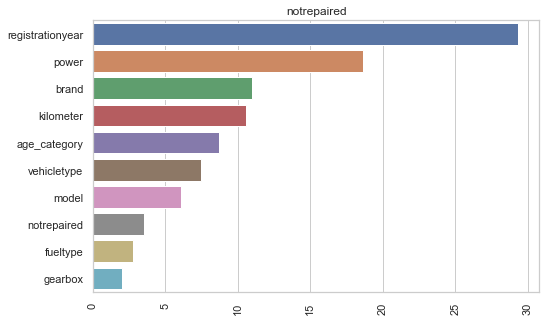

In [114]:
plt.figure(figsize=(8,5))
sns.set(style="whitegrid")
sns.barplot(x=feature_importans_cat, y=feature_importans_cat.index);
plt.title(feature, fontsize=12)
plt.xticks(rotation = 90)
plt.show()

In [94]:
%%time

#подберем параметры
cat = CatBoostRegressor(silent=True)

grid = {'learning_rate': [0.03, 0.1, 0.3],
        'depth': [5, 10, 12],
        'l2_leaf_reg': [0.3, 0.5, 1.0]}

grid_search_result = cat.grid_search(grid, X=data_train_ord, y=target_train)
print(grid_search_result['params'])


bestTest = 1735.459275
bestIteration = 999

0:	loss: 1735.4592749	best: 1735.4592749 (0)	total: 20.1s	remaining: 8m 43s

bestTest = 1645.40555
bestIteration = 999

1:	loss: 1645.4055500	best: 1645.4055500 (1)	total: 40.8s	remaining: 8m 30s

bestTest = 1603.456526
bestIteration = 992

2:	loss: 1603.4565257	best: 1603.4565257 (2)	total: 1m 1s	remaining: 8m 10s

bestTest = 1734.966852
bestIteration = 999

3:	loss: 1734.9668519	best: 1603.4565257 (2)	total: 1m 22s	remaining: 7m 53s

bestTest = 1649.864599
bestIteration = 999

4:	loss: 1649.8645992	best: 1603.4565257 (2)	total: 1m 42s	remaining: 7m 32s

bestTest = 1597.386555
bestIteration = 991

5:	loss: 1597.3865551	best: 1597.3865551 (5)	total: 2m 2s	remaining: 7m 10s

bestTest = 1734.995016
bestIteration = 999

6:	loss: 1734.9950164	best: 1597.3865551 (5)	total: 2m 23s	remaining: 6m 50s

bestTest = 1647.966405
bestIteration = 998

7:	loss: 1647.9664052	best: 1597.3865551 (5)	total: 2m 45s	remaining: 6m 34s

bestTest = 1602.738433
bestI

In [95]:
cat2 = CatBoostRegressor(depth=12, learning_rate=0.1, l2_leaf_reg=1.0, silent=True)
result = cross_val_score(cat2, data_train_ord, target_train, cv=5, scoring=scoring);

time_fit_start = datetime.now()
cat2.fit(data_train_ord, target_train)
time_fit_end = datetime.now()
time_fit_diff = time_fit_end - time_fit_start

time_pred_start = datetime.now()
cat2.predict(data_train_ord)
time_pred_end = datetime.now()
time_pred_diff = time_pred_end - time_pred_start

print('RMSE CatBoost с подбором параметров:', result.mean())
print('Время обучения алгоритма:', time_fit_diff)
print('Время предсказания:', time_pred_diff)
score_table = (score_table.append({'model': 'CatBoost customized', 'RMSE': result.mean(), 
                                   'fit time': time_fit_diff, 'pred time': time_pred_diff}, ignore_index=True));

RMSE CatBoost с подбором параметров: -1542.2856372467224
Время обучения алгоритма: 0:01:50.441762
Время предсказания: 0:00:01.848079


Даже без подбора гиперпараметров CatBoost дал результат лучше, чем метод ближайших соседей. Однако время работы алоритма заметно больше, чем у ближайших соседей.

**Light GBM**

In [96]:
%%time

#LGBM без подбора гиперпараметров
lgbm = LGBMRegressor()
result = cross_val_score(lgbm, data_train_ord, target_train, cv=5, scoring=scoring);

time_fit_start = datetime.now()
lgbm.fit(data_train_ord, target_train)
time_fit_end = datetime.now()
time_fit_diff = time_fit_end - time_fit_start

time_pred_start = datetime.now()
lgbm.predict(data_train_ord)
time_pred_end = datetime.now()
time_pred_diff = time_pred_end - time_pred_start

print('RMSE LGBM simple:', result.mean())
print('Время обучения алгоритма:', time_fit_diff)
print('Время предсказания:', time_pred_diff)
score_table = (score_table.append({'model': 'LGBM simple', 'RMSE': result.mean(), 
                                   'fit time': time_fit_diff, 'pred time': time_pred_diff}, ignore_index=True));

RMSE LGBM simple: -1693.6502799938407
Время обучения алгоритма: 0:00:01.308239
Время предсказания: 0:00:00.624854
Wall time: 7.77 s


Подберем boosting_type, n_estimators, learning_rate и max_depth последовательно, чтобы уменьшить время

In [97]:
%%time

lgbm = LGBMRegressor()
grid_params = {'boosting_type': ['goss', 'gbdt']}
lgbm2 = GridSearchCV(lgbm, grid_params, scoring=scoring)
lgbm2.fit(data_train_ord, target_train)

print(lgbm2.best_estimator_)

result = cross_val_score(lgbm2.best_estimator_, data_train_ord, target_train, cv=5, scoring=scoring);

print('LGMB customized:', result.mean())

LGBMRegressor(boosting_type='goss')
LGMB customized: -1690.8069759353996
Wall time: 22.4 s


In [98]:
%%time

lgbm = LGBMRegressor()
grid_params = {'boosting_type': ['goss'],
              'n_estimators': [100, 500, 1000, 2000, 3000, 5000]}
lgbm2 = GridSearchCV(lgbm, grid_params, scoring=scoring)
lgbm2.fit(data_train_ord, target_train)

print(lgbm2.best_estimator_)

result = cross_val_score(lgbm2.best_estimator_, data_train_ord, target_train, cv=5, scoring=scoring);

print('LGMB customized:', result.mean())

LGBMRegressor(boosting_type='goss', n_estimators=2000)
LGMB customized: -1541.1873787261352
Wall time: 14min 44s


In [100]:
%%time

lgbm = LGBMRegressor()
grid_params = {'boosting_type': ['goss'],
              'n_estimators': [2000],
              'learning_rate': [0.01, 0.1, 0.3]}
lgbm2 = GridSearchCV(lgbm, grid_params, scoring=scoring)
lgbm2.fit(data_train_ord, target_train)

print(lgbm2.best_estimator_)

result = cross_val_score(lgbm2.best_estimator_, data_train_ord, target_train, cv=5, scoring=scoring);

print('LGMB customized:', result.mean())

LGBMRegressor(boosting_type='goss', n_estimators=2000)
LGMB customized: -1541.1873787261352
Wall time: 8min 39s


In [101]:
%%time

lgbm = LGBMRegressor()
grid_params = {'boosting_type': ['goss'],
              'n_estimators': [3000],
              'max_depth': [3, 5, 10, 12, 15]}
lgbm2 = GridSearchCV(lgbm, grid_params, scoring=scoring)
lgbm2.fit(data_train_ord, target_train)

print(lgbm2.best_estimator_)

result = cross_val_score(lgbm2.best_estimator_, data_train_ord, target_train, cv=5, scoring=scoring);

time_fit_start = datetime.now()
model = lgbm2.best_estimator_
model.fit(data_train_geo_ohe, target_train)
time_fit_end = datetime.now()
time_fit_diff = time_fit_end - time_fit_start

time_pred_start = datetime.now()
model.predict(data_train_geo_ohe)
time_pred_end = datetime.now()
time_pred_diff = time_pred_end - time_pred_start

print('RMSE LGBM customized:', result.mean())
print('Время обучения алгоритма:', time_fit_diff)
print('Время предсказания:', time_pred_diff)
score_table = (score_table.append({'model': 'LGBM customized', 'RMSE': result.mean(), 
                                   'fit time': time_fit_diff, 'pred time': time_pred_diff}, ignore_index=True));


LGBMRegressor(boosting_type='goss', max_depth=10, n_estimators=3000)
RMSE LGBM customized: -1541.763576936349
Время обучения алгоритма: 0:00:45.832032
Время предсказания: 0:00:38.817538
Wall time: 19min 11s


LGBM дал наилучший результат из всех опробованных моделей, оторвавшись от CatBoost на единицу). Длительность его работы заметно выше ближайших соседей, но сравнима с CatBoost.

**Проверка модели на адекватность**

In [102]:
dummy = DummyRegressor(strategy='mean')
dummy.fit(data_train_ord, target_train)
result = cross_val_score(dummy, data_train_ord, target_train, cv=5, scoring=scoring)
print('Dummy:', result.mean())

Dummy: -4552.327506403274


In [103]:
score_table.sort_values('RMSE')

,model,RMSE,fit time,pred time
5,KNeighborsRegressor geo,-3263.011988,0 days 00:00:02.231037,0 days 00:00:09.880921
2,ElasticNet,-2384.624374,0 days 00:00:14.073007,0 days 00:00:00.374913
3,ElasticNet geo,-2383.569247,0 days 00:00:18.045040,0 days 00:00:00.343669
0,LinearRegression,-2264.759458,0 days 00:00:05.873629,0 days 00:00:00.390534
1,LinearRegression geo,-2263.752663,0 days 00:00:05.906129,0 days 00:00:00.374912
4,KNeighborsRegressor,-1778.597445,0 days 00:00:01.961957,0 days 00:00:09.482785
9,LGBM simple,-1693.650280,0 days 00:00:01.308239,0 days 00:00:00.624854
6,CatBoost simple,-1607.826339,0 days 00:00:26.707191,0 days 00:00:00.140593
7,CatBoost simple cat,-1601.149881,0 days 00:03:46.160044,0 days 00:00:01.715111
8,CatBoost customized,-1542.285637,0 days 00:01:50.441762,0 days 00:00:01.848079


### Выводы

Мы обучили 5 моделей: линейную регрессию, ElasticNet, CatBoost, LGBM и метод ближайших соседей. Лучший результат показал Light GBM - однако у модели достаточно большое время обучения. У метода ближайших соседей точность ниже, но время работы выше. Для тестирования опробуем две эти модели и сравним не только результат, но и время работы.</br>
Включение почтового индекса в данные не дает значимого улучшения RMSE.

## Тестирование моделей

**Метод ближайших соседей**

In [120]:
%%time
knr_last = knr
knr_last.fit(data_train_ord, target_train)

Wall time: 2.01 s


KNeighborsRegressor()

In [121]:
%%time
predictions = knr_last.predict(data_test_ord)

Wall time: 2.5 s


In [122]:
print('RMSE на тестовой выборке для ближайших соседей:', rmse(target_test, predictions))

RMSE на тестовой выборке для ближайших соседей: 1774.1360254610997


**Light GBM**

In [123]:
%%time
lgbm_last = lgbm2.best_estimator_
lgbm_last.fit(data_train_ord, target_train)

Wall time: 34.9 s


LGBMRegressor(boosting_type='goss', max_depth=10, n_estimators=3000)

In [124]:
%%time
predictions = lgbm_last.predict(data_test_ord)

Wall time: 8.59 s


In [125]:
print('RMSE на тестовой выборке для ближайших соседей:', rmse(target_test, predictions))

RMSE на тестовой выборке для ближайших соседей: 1544.5425675148722


## Общий вывод

В данном проекте была разработана модель, предсказывающая рыночную стоимость автомобиля по его характеристиками.</br>
Была проведена предобработка данных, удаление неинформативных объектов и выбросов, восстановление пропусков. Всего в процессе предобработки удалено 9% датасета. Обучение и тестирование проводилось на 322 365 записях.</br>
Были отобраны признаки, проведено кодирование категориальных признаков, изучено влияние почтового индекса на точность предсказания (низкое).</br>
Для обучения были рассмотрены: LinearRegression, ElasticNet, KNeighborsRegressor, CatBoostRegressor, LGBMRegressor. Лучшие результаты по точности и времени работы показали LGBM и KNeighbors.